In [1]:
import abc
from collections import *
import random
from typing import *

import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
"""
Tic Tac Toe implementation
"""

EMPTY = 0
PLAYER = 1
OPPONENT = -1

Move = Tuple[int, int]
PlayerId = int
Reward = float

COORDINATES = [
    (1, 1),                             # Middle first
    (0, 0), (2, 0), (0, 2), (2, 2),     # Corners
    (1, 0), (0, 1), (1, 2), (2, 1)      # The rest
]

COMBINATIONS = [
    # diagonals
    {(0, 0), (1, 1), (2, 2)},
    {(2, 0), (1, 1), (0, 2)},
    # rows
    {(0, 0), (0, 1), (0, 2)},
    {(1, 0), (1, 1), (1, 2)},
    {(2, 0), (2, 1), (2, 2)},
    # cols
    {(0, 0), (1, 0), (2, 0)},
    {(0, 1), (1, 1), (2, 1)},
    {(0, 2), (1, 2), (2, 2)}
]

def next_player(player: PlayerId):
    if player == PLAYER:
        return OPPONENT
    return PLAYER

class TicTacToe:
    def __init__(self, grid):
        self.grid = grid
    
    @classmethod
    def empty(cls):
        return cls(grid=np.zeros(shape=(3, 3)))
    
    def clone(self):
        return TicTacToe(grid=self.grid.copy())
    
    def __eq__(self, other):
        return np.array_equal(self.grid, other.grid)
    
    def __hash__(self):
        return hash(self.grid.tostring())

    def available_moves(self):
        moves = []
        for move in COORDINATES:
            if self.grid[move] == EMPTY:
                moves.append(move)
        return moves
    
    def play(self, player: PlayerId, move: Move) -> Reward:
        if self.grid[move] != EMPTY:
            raise Exception("Invalid move: " + str(move) + "for grid" + str(self.grid))
        
        self.grid[move] = player
        winner = self.winner()
        if winner == player:
            return 1
        elif winner == next_player(player):
            return -1
        return 0
    
    def is_over(self) -> bool:
        return self.filled() or self.winner() != EMPTY
    
    def winner(self):
        for combi in COMBINATIONS:
            player_count = 0
            opponent_count = 0
            for position in combi:
                if self.grid[position] == PLAYER:
                    player_count += 1
                elif self.grid[position] == OPPONENT:
                    opponent_count += 1
            if player_count == 3:
                return PLAYER
            elif opponent_count == 3:
                return OPPONENT
        return EMPTY
    
    def filled(self):
        for pos in COORDINATES:
            if self.grid[pos] == EMPTY:
                return False
        return True

In [3]:
"""
A famous way to win a game
x x o
    x
o   o
"""

game = TicTacToe.empty()
print(game.play(PLAYER, (0, 0)))
print(game.play(OPPONENT, (2, 2)))
print(game.play(PLAYER, (0, 1)))
print(game.play(OPPONENT, (0, 2)))
print(game.play(PLAYER, (1, 2)))
print(game.play(OPPONENT, (2, 0)))
print(game.grid)
print(game.play(PLAYER, (1, 1)))
print(game.play(OPPONENT, (2, 1)))
print(game.grid)
print("winner:", game.winner())

assert TicTacToe.empty() == TicTacToe.empty()
assert hash(TicTacToe.empty()) == hash(TicTacToe.empty())

0
0
0
0
0
0
[[ 1.  1. -1.]
 [ 0.  0.  1.]
 [-1.  0. -1.]]
0
1
[[ 1.  1. -1.]
 [ 0.  1.  1.]
 [-1. -1. -1.]]
winner: -1


In [4]:
"""
An environment for an agent to play against
"""


class Agent(abc.ABC):    
    @abc.abstractmethod
    def get_action(self, game: TicTacToe) -> Move:
        pass


class TicTacToeEnv:
    def __init__(self, opponent: Agent):
        self.game: TicTacToe = TicTacToe.empty()
        self.opponent: Agent = opponent
    
    def reset(self):
        self.game = TicTacToe.empty()
        if random.choice([PLAYER, OPPONENT]) == OPPONENT:
            move = self.opponent.get_action(self.game)
            self.game.play(OPPONENT, move)
        return self.state
        
    @property
    def state(self):
        return self.game.grid
    
    def is_over(self):
        return self.game.is_over()
    
    def step(self, move: Move) -> Reward:
        self.game = self.game.clone()
        reward = self.game.play(PLAYER, move)
        if self.game.is_over():
            return reward
        
        move = self.opponent.get_action(self.game)
        reward = self.game.play(OPPONENT, move)
        return -1 * reward

In [5]:
"""
Trying out the environment with another random agent
"""


class FirstMoveAgent(Agent):
    def get_action(self, game: TicTacToe) -> Move:
        return game.available_moves()[0]


class RandomAgent(Agent):
    def __init__(self):
        pass
    
    def get_action(self, game: TicTacToe) -> Move:
        moves = game.available_moves()
        return random.choice(moves)


def play_episode(env, agent, with_log=False):
    total_reward = 0.
    env.reset()
    while not env.is_over():
        if with_log:
            print(env.game.grid)
        move = agent.get_action(env.game)
        reward = env.step(move)
        total_reward += reward
    if with_log:
        print(env.game.grid)
    return total_reward, env.state


env=TicTacToeEnv(opponent=RandomAgent())

print("Basic stats: random vs random")
stats = defaultdict(int)
for _ in range(1000):
    result, _ = play_episode(env, agent=RandomAgent())
    stats[result] += 1
print(stats)

print("Basic stats: random vs first move")
stats = defaultdict(int)
for _ in range(1000):
    result, _ = play_episode(env, agent=FirstMoveAgent())
    stats[result] += 1
print(stats)

Basic stats: random vs random
defaultdict(<class 'int'>, {1.0: 434, -1.0: 435, 0.0: 131})
Basic stats: random vs first move
defaultdict(<class 'int'>, {1.0: 724, -1.0: 217, 0.0: 59})


In [6]:
"""
All powerful agent: search throught he whole state space
"""


class AllKnowingAI(Agent):
    def __init__(self, player: PlayerId):
        self.player = player
        self.memo = {}
    
    def get_action(self, game: TicTacToe) -> Move:
        return self._best_action(game, self.player)[0]

    def _best_action(self, game: TicTacToe, player: PlayerId) -> Tuple[Move, Reward]:
        if (game, player) in self.memo:
            return self.memo[(game, player)]

        if game.is_over():
            return None, 0.

        best_move = None
        best_score = -2.0
        for move in game.available_moves():
            next_game = game.clone()
            score = next_game.play(player, move)                
            _, next_score = self._best_action(next_game, next_player(player))
            score -= 0.9 * next_score  # negate the score of opponent + discount it to prefer early victories
            if score > best_score:
                best_score = score
                best_move = move

        self.memo[(game, player)] = best_move, best_score
        return best_move, best_score
        

"""
Trying this agent
"""


env=TicTacToeEnv(opponent=RandomAgent())
result, state = play_episode(env, agent=AllKnowingAI(player=PLAYER), with_log=True)
print(result)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]
[[ 1.  0. -1.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]
[[ 1.  0. -1.]
 [ 0.  1.  1.]
 [-1.  0. -1.]]
[[ 1.  0. -1.]
 [ 1.  1.  1.]
 [-1.  0. -1.]]
1.0


In [7]:
"""
Tabular Value Learning

There is a BIG PROBLEM HERE:
- We can easily learn the value function by observing, but...
- How would you PICK THE NEXT ACTION with the highest value (to select it)?
=> The only possibility would be to have a model of the environment (replicate the behavior of the agent inside the env)
"""

print("Harder than Q-Learning")

Harder than Q-Learning


In [8]:
"""
Tabular Q-Learning
"""


class QValues(Agent):
    def __init__(self):
        self.q_values = defaultdict(lambda: defaultdict(float))
    
    def __repr__(self):
        return repr(self.q_values)
    
    def get_action(self, game: TicTacToe) -> Move:
        best_move = None
        best_score = float('-inf')
        for move, score in self.q_values[game].items():
            if score > best_score:
                best_score = score
                best_move = move
        if best_move is None:
            best_move = random.choice(game.available_moves())
        return best_move
    
    def get_value(self, game: TicTacToe, move: Move) -> Reward:
        return self.q_values[game][move]
    
    def update_toward(self, game: TicTacToe, move: Move, target_value: Reward, learning_rate: float):
        self.q_values[game][move] += learning_rate * (target_value - self.q_values[game][move])
        # or alternatively:
        # self.q_values[game][move] = current_value * (1 - learning_rate) + learning_rate * target_value

        
"""
Q-Learning
"""

        
def q_learning(
    q_values: QValues, env: TicTacToeEnv, episodes: int,
    discount: float, learning_rate: float,
    epsilon: float, min_epsilon: float, epsilon_decrease: float):

    episode_rewards = []
    targets = []
    epsilons = []

    for _ in trange(episodes):
        env.reset()

        total_reward = 0.        
        while not env.is_over():
            game = env.game
            if np.random.rand(1) < epsilon:
                move = random.choice(game.available_moves())
            else:
                move = q_values.get_action(game)                        
            reward = env.step(move)
            total_reward += reward

            next_game = env.game
            if next_game.is_over():
                if env.game.winner() == PLAYER:
                    epsilon = max(min_epsilon, epsilon_decrease * epsilon)
                target_value = reward
            else:
                next_move = q_values.get_action(next_game)
                next_value = q_values.get_value(next_game, next_move)
                target_value = reward + discount * next_value

            targets.append(target_value)
            q_values.update_toward(game, move, target_value, learning_rate)

        episode_rewards.append(total_reward)
        epsilons.append(epsilon)

    # Reporting
    fig, ax = plt.subplots(figsize=(15, 10), nrows=3)
    ax[0].plot(episode_rewards, label="rewards")
    ax[0].plot(pd.Series(episode_rewards).rolling(50).mean(), label="mean rewards")
    ax[1].plot(epsilons, label="epsilon")
    ax[2].plot(targets, label="targets")
    for p in ax:
        p.legend()
    plt.show()
    
    
"""
N-step Q-Learning
"""


def n_step_q_learning(
    q_values: QValues, env: TicTacToeEnv, episodes: int,
    discount: float, learning_rate: float,
    epsilon: float, min_epsilon: float, epsilon_decrease: float,
    step: int):

    episode_rewards = []

    for _ in trange(episodes):
        env.reset()

        total_reward = 0.
        memory = deque(maxlen=step)
        
        while not env.is_over():
            game = env.game
            if np.random.rand(1) < epsilon:
                move = random.choice(game.available_moves())
            else:
                move = q_values.get_action(game)                        
            reward = env.step(move)
            total_reward += reward
            
            memory.append((game, move, reward))

            next_game = env.game
            if next_game.is_over():
                if env.game.winner() == PLAYER:
                    epsilon = max(min_epsilon, epsilon_decrease * epsilon)
                target_value = 0.
                for game, move, reward in reversed(memory):
                    target_value = reward + discount * target_value
                    q_values.update_toward(game, move, target_value, learning_rate)
                
            elif len(memory) == step:
                cum_discount = discount
                first_game, first_move, sum_reward = memory.popleft()
                for _, _, reward in memory:
                    sum_reward += cum_discount * reward
                    cum_discount *= discount
                next_move = q_values.get_action(next_game)
                next_value = q_values.get_value(next_game, next_move)
                target_value = sum_reward + discount * next_value
                q_values.update_toward(first_game, first_move, target_value, learning_rate)

        episode_rewards.append(total_reward)

    return episode_rewards


"""
With eligibility traces
"""


# TODO


"""
With Double Q-Learning
"""


# TODO


"""
With planning
"""


# TODO

'\nWith planning\n'

100%|██████████| 50000/50000 [00:35<00:00, 1395.38it/s]


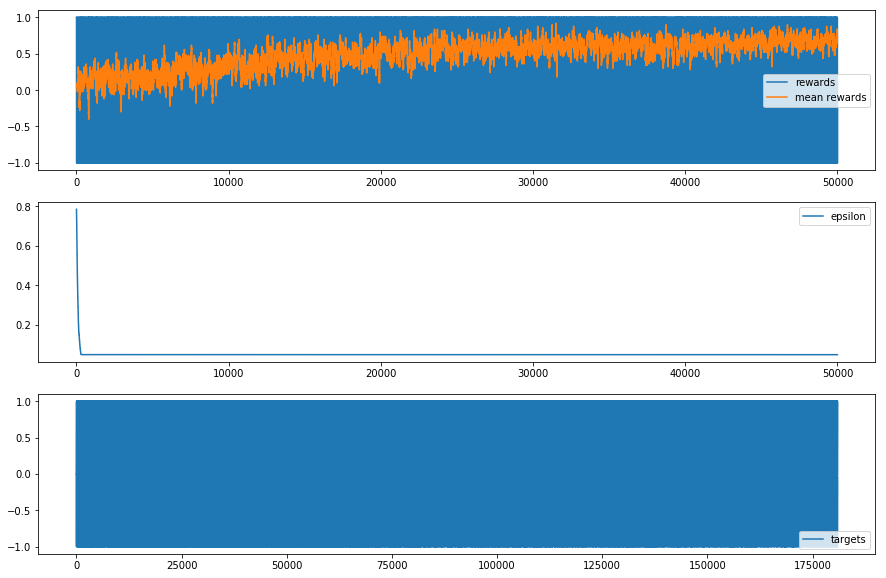

Efficiency at the end
defaultdict(<class 'int'>, {1.0: 809, -1.0: 93, 0.0: 98})


In [9]:
"""
Q-Learning against a random agent
"""


env=TicTacToeEnv(opponent=RandomAgent())

random.seed(1)
np.random.seed(1)
q_values = QValues()
q_learning(q_values, env, episodes=50_000, discount=0.99, learning_rate=0.02, epsilon=0.8, min_epsilon=0.05, epsilon_decrease=0.98)

print("Efficiency at the end")
stats = defaultdict(int)
for _ in range(1000):
    result, _ = play_episode(env, agent=q_values)
    stats[result] += 1
print(stats)

100%|██████████| 1000/1000 [00:00<00:00, 1445.62it/s]


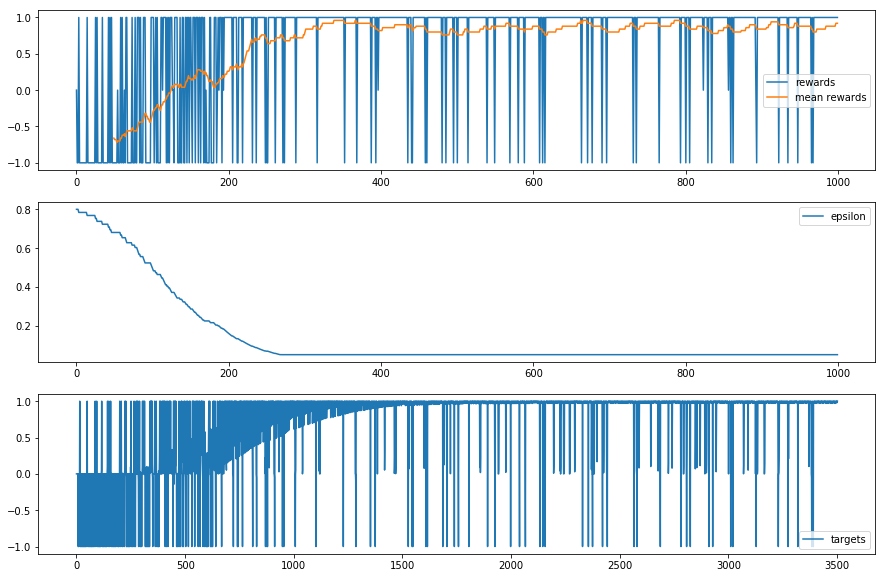

Efficiency at the end
defaultdict(<class 'int'>, {1.0: 1000})


In [9]:
"""
Q-Learning against a first move agent
"""


env=TicTacToeEnv(opponent=FirstMoveAgent())
q_values = QValues()

random.seed(1)
np.random.seed(1)
q_learning(q_values, env, episodes=1000, discount=0.99, learning_rate=0.05, epsilon=0.8, min_epsilon=0.05, epsilon_decrease=0.98)


print("Efficiency at the end")
stats = defaultdict(int)
for _ in range(1000):
    result, _ = play_episode(env, agent=q_values)
    stats[result] += 1
print(stats)

100%|██████████| 1000/1000 [00:00<00:00, 1199.76it/s]


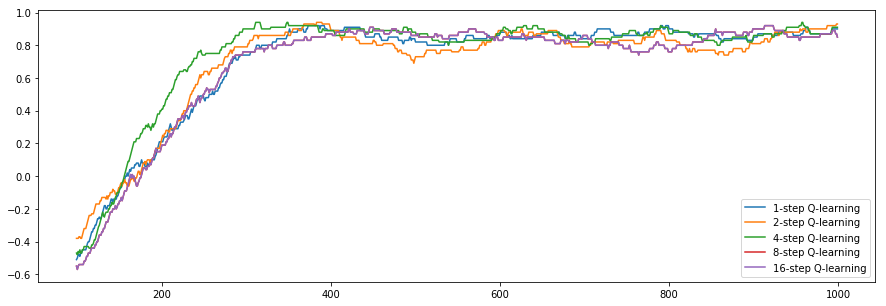

In [10]:
"""
Trying with different N-step values
"""


env=TicTacToeEnv(opponent=FirstMoveAgent())

all_rewards = []

for step in (1, 2, 4, 8, 16):
    q_values = QValues()
    random.seed(1)
    np.random.seed(1)
    episode_rewards = n_step_q_learning(
        q_values, env, episodes=1_000,
        discount=0.99, learning_rate=0.05,
        epsilon=0.8, min_epsilon=0.05, epsilon_decrease=0.98,
        step=step)
    all_rewards.append((step, episode_rewards))
    
# Reporting
fig, ax = plt.subplots(figsize=(15, 5))
for step, episode_rewards in all_rewards:
    ax.plot(pd.Series(episode_rewards).rolling(100).mean(), label=str(step)+"-step Q-learning")
ax.legend()
plt.show()

100%|██████████| 1000/1000 [00:03<00:00, 259.92it/s]


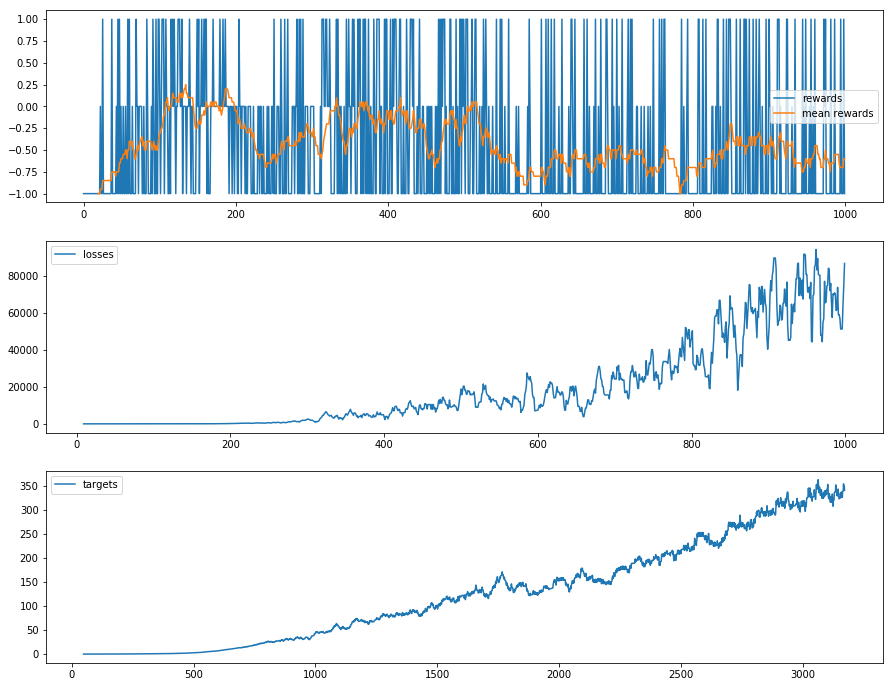

In [84]:
"""
Approximate Q-Learning, using Deep Learning techniques
"""


class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=3*3, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=9))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, xs, with_softmax=False):
        xs = torch.FloatTensor(xs)
        if len(xs.shape) == 2:
            xs = xs.unsqueeze(dim=0)
        batch_size, h, w = xs.shape
        xs = xs.reshape((batch_size, h * w))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs


"""
Training loop
"""


# TODO - do this inside the environment? INSTEAD: encapsulate in an agent...
def get_move_index(move: Move):
    return COORDINATES.index(move)


# TODO - do this inside the environment? INSTEAD: encapsulate in an agent...
def mask_invalid_actions(game: TicTacToe, action_probs: torch.Tensor) -> torch.Tensor:
    available = set(game.available_moves())
    mask = torch.zeros(size=(1,9), dtype=torch.uint8)
    for i, move in enumerate(COORDINATES):
        if move in available:
            mask[(0, i)] = 1
    action_probs[~mask] = 0.
    return action_probs


def best_of_available_moves(game: TicTacToe, action_probs: torch.Tensor) -> Move:
    action_probs_masked = mask_invalid_actions(game, action_probs)
    if action_probs_masked.sum() > 0: # TODO - sometimes, the probas are all zeros
        _, i = torch.max(action_probs_masked, dim=-1)
        return COORDINATES[i]
    else:
        return random.choice(game.available_moves())


def train_q_learning_policy(
    env, policy: nn.Module, episodes: int, discount: float,
    start_epsilon: float, min_epsilon: float, epsilon_decrease: float,
    learning_rate: float, learning_rate_decay: float,
    weight_decay: float):
    
    episode_rewards = []
    episode_losses = []
    target_values = []
    epsilon = start_epsilon

    criterion = nn.MSELoss()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=learning_rate_decay)

    for episode in trange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        env.reset()

        while not env.is_over():
            game = env.game
            
            # Epsilon greedy action
            # Note that it would not be correct to use a softmax on the Q-values
            # => you should go for policy gradient algorithms to do this
            if np.random.rand(1) < epsilon:
                move = random.choice(game.available_moves())
            else:
                action_probs = policy(game.grid, with_softmax=True)
                move = best_of_available_moves(game, action_probs)
            
            try:
                reward = env.step(move)
            except Exception as e:
                # TODO - understand how I get wrong moves
                # TODO - loss explosion might be linked?
                
                action_values = policy(game.grid)
                action_probs = policy(game.grid, with_softmax=True)
                move = best_of_available_moves(game, action_probs)
                print(game.grid)
                print(action_values)
                print(action_probs)
                print(get_move_index(move))
                print(move)
                raise e
            
            # Get the target value
            next_game = env.game
            if next_game.is_over():
                if env.game.winner() == PLAYER:
                    epsilon = max(min_epsilon, epsilon_decrease * epsilon)
                target_value = reward
            else:
                next_action_values = policy(next_game.grid, with_softmax=False)
                next_value, _ = torch.max(next_action_values, dim=-1)
                target_value = reward + discount * next_value.item()

            # Calculate loss & Update policy
            action_values = policy(game.grid, with_softmax=False).squeeze(dim=0)
            action_value = action_values[get_move_index(move)]
            optimizer.zero_grad()
            loss = criterion(action_value, torch.tensor(target_value, dtype=torch.float32))
            loss.backward()
            optimizer.step()

            # Record history
            episode_reward += reward
            episode_loss += loss.item()
            target_values.append(target_value)
        
        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
    ax[0].plot(episode_rewards, label="rewards")
    ax[0].plot(pd.Series(episode_rewards).rolling(20).mean(), label="mean rewards")
    ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
    ax[2].plot(pd.Series(target_values).rolling(50).sum() / 100., label="targets")
    for p in ax:
        p.legend()
    plt.show()


env=TicTacToeEnv(opponent=FirstMoveAgent())

policy_1 = Policy()
torch.manual_seed(1);
np.random.seed(1)
train_q_learning_policy(
    env, policy=policy_1, episodes=1000, discount=0.99,
    start_epsilon=0.5, min_epsilon=0.0, epsilon_decrease=0.95,
    learning_rate=1e-3, learning_rate_decay=1.0,
    weight_decay=1e-3)

In [83]:
print(policy_1)
for param in policy_1.parameters():
    print(param.data.max())
    
print(policy_2)
for param in policy_2.parameters():
    print(param.data.max())

Policy(
  (fc): Sequential(
    (0): Linear(in_features=9, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=9, bias=True)
  )
  (softmax): Softmax()
)
tensor(3.3779)
tensor(4.6751)
tensor(2.9934)
tensor(2.2929)
Policy(
  (fc): Sequential(
    (0): Linear(in_features=9, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=9, bias=True)
  )
  (softmax): Softmax()
)
tensor(4.6477)
tensor(5.8692)
tensor(3.7933)
tensor(3.3530)
